# Predicting Sepsis Survival Based on Clinical Records

## Summary

To be filled after conclusion

## Introduction

Sepsis is a life-threatening condition that occurs when the immune system overreacts to an infection causing organ dysfunction (Cleveland Clinic, 2022). The reaction can cause damage to tissues and organs and it can lead to severe sepsis from low blood pressure as a result of inflammation throughout the body. The last stage is septic shock which is when blood pressure is so low that it cannot supply enough blood to vital organs such as the brain, kidneys, and liver, causing them to fail and possibly leading to death. Generally, sepsis is usually caused by bacterial infections but it could be from parasites, viruses, and fungi infections in the bloodstream, lungs. and urinary tract (World Health Organization, 2024).  Common symptoms for sepsis include fever, fast heart rate, rapid breathing, low blood pressure, confusion, skin rash, chills and shivering, etc (Canadian Cancer Society, 2024).

Since sepsis requires urgent medical care, a machine learning algorithm that can be used to predict if a patient is likely to survive or pass away after being hospitalized for a specific time interval from septic shock is crucial. Sepsis is often associated with immediate death risk and it can kill patients as fast as within an hour if not treated promptly. An accurate and fast machine learning model will help medical staff prioritize patients who need more urgent care and possibly save more patients from this life-threatening condition. Also, this study aims to identify which factor contributes to whether a patient is more likely to be dead from sepsis. Therefore, if a machine learning algorithm can promptly and accurately classify patients, this could lead to a better sepsis patient prioritization and save more lives.

To answer this question and produce a machine learning model, the datasets of 110,204 admissions of 84,811 hospitalized subjects between 2011 and 2012 in Norway who were diagnosed with infections, systemic inflammatory response syndrome, sepsis by causative microbes, or septic shock will be utilized to analyze and build a machine learning algorithm. It was sourced from the UCI Machine Learning Repository (Chicco & Jurman, 2020). Each row in the data set represents each patient information including their age, sex, and number of prior sepsis episodes. There is an outcome of each patient whether they survive at a time of about 9 days after being hospitalized in each row. All the patients' admissions are only defined by the novel Sepsis-3 definition.

## Methods

EDA is conducted first to see if any data wrangling is needed before proceeding to building a machine learning model.

In [1]:
# Import all the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import zipfile
import io
import requests

In [2]:
# URL of the outer zip
url = "https://archive.ics.uci.edu/static/public/827/sepsis%2Bsurvival%2Bminimal%2Bclinical%2Brecords.zip"

# Download the outer zip
r = requests.get(url)
outer_zip = zipfile.ZipFile(io.BytesIO(r.content))

# Look inside (you should see one file)
print("Outer zip contains:", outer_zip.namelist())

# Extract the inner zip file
inner_zip_name = outer_zip.namelist()[0]
inner_zip_bytes = outer_zip.read(inner_zip_name)

# Open the inner zip
inner_zip = zipfile.ZipFile(io.BytesIO(inner_zip_bytes))

# List files inside the inner zip
print("Inner zip contains:", inner_zip.namelist())

Outer zip contains: ['s41598-020-73558-3_sepsis_survival_dataset.zip']
Inner zip contains: ['s41598-020-73558-3_sepsis_survival_primary_cohort.csv', 's41598-020-73558-3_sepsis_survival_study_cohort.csv', 's41598-020-73558-3_sepsis_survival_validation_cohort.csv']


In [3]:
with inner_zip.open('s41598-020-73558-3_sepsis_survival_primary_cohort.csv') as f:
    train_df = pd.read_csv(f)

# Rename column names 
train_df = train_df.rename(columns={
    'age_years': 'age',
    'sex_0male_1female': 'sex',
    'hospital_outcome_1alive_0dead': 'hospital_outcome',
})

train_df

,age,sex,episode_number,hospital_outcome
0,21,1,1,1
1,20,1,1,1
2,21,1,1,1
3,77,0,1,1
4,72,0,1,1
...,...,...,...,...
110199,0,0,1,1
110200,0,1,1,1
110201,70,1,1,1
110202,0,0,1,1


In [4]:
with inner_zip.open('s41598-020-73558-3_sepsis_survival_study_cohort.csv') as f:
    test_df = pd.read_csv(f)

# Rename column names 
test_df = test_df.rename(columns={
    'age_years': 'age',
    'sex_0male_1female': 'sex',
    'hospital_outcome_1alive_0dead': 'hospital_outcome',
})

test_df

,age,sex,episode_number,hospital_outcome
0,7,1,1,1
1,17,0,2,1
2,70,0,1,1
3,76,0,1,1
4,8,0,1,1
...,...,...,...,...
19046,33,1,1,1
19047,58,0,1,1
19048,44,0,2,1
19049,61,0,3,0


In [5]:
# Show the stats of each column
train_df.describe()

,age,sex,episode_number,hospital_outcome
count,110204.000000,110204.000000,110204.000000,110204.000000
mean,62.735255,0.473948,1.349379,0.926455
std,24.126806,0.499323,0.751799,0.261031
min,0.000000,0.000000,1.000000,0.000000
25%,51.000000,0.000000,1.000000,1.000000
50%,68.000000,0.000000,1.000000,1.000000
75%,81.000000,1.000000,1.000000,1.000000
max,100.000000,1.000000,5.000000,1.000000


In [6]:
# Check if there are any NAs in the train df
train_df.isna().mean()

age                 0.0
sex                 0.0
episode_number      0.0
hospital_outcome    0.0
dtype: float64

In [7]:
# Check if there are any NAs in the test df
test_df.isna().mean()

age                 0.0
sex                 0.0
episode_number      0.0
hospital_outcome    0.0
dtype: float64

From the current train and test datasets, all the data are already clean. Age is an integer from 0 to 100. Sex is either 0 (Male) or 1 (Female). Number of prior Sepsis episodes is an integer ranging from 1 to 5. There are no NA values in any columns, so no data imputation is needed.

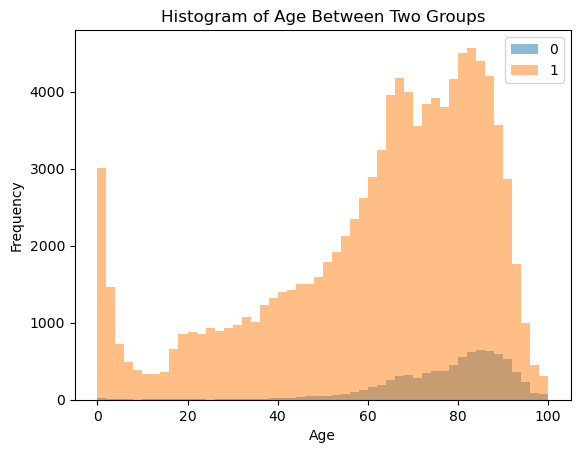

In [8]:
# Visualize histogram of the age feature grouped by hospital_outcome
train_df.groupby("hospital_outcome")['age'].plot.hist(
    bins=50, alpha=0.5, legend=True, density = False, title = "Histogram of Age Between Two Groups");
plt.xlabel("Age")
plt.show()

In [27]:
# Visualize Episode number & Sex VS Outcome by using bar plot
alt.data_transformers.enable('vegafusion')

episode_number_plot = (
    alt.Chart(train_df, title="Hospital Outcome by Episode Number")
    .mark_bar()
    .encode(
        x=alt.X('episode_number:N', title='Episode Number'),
        y=alt.Y('count()', title='Count'),
        color=alt.Color('hospital_outcome:N', title='Outcome'),
        xOffset='hospital_outcome:N')
)

sex_plot = (
    alt.Chart(train_df, title="Hospital Outcome by Sex")
    .mark_bar()
    .encode(
        x=alt.X('sex:N', title='Sex'),
        y=alt.Y('count()', title='Count'),
        color=alt.Color('hospital_outcome:N', title='Outcome'),
        xOffset='hospital_outcome:N')
)

# Show the plot
episode_number_plot | sex_plot

alt.HConcatChart(...)

We can see from the histogram and bar plots above that there is an imbalance of datasets between alive patients and dead patients. This needs to be taken into account when building a machine learning model.

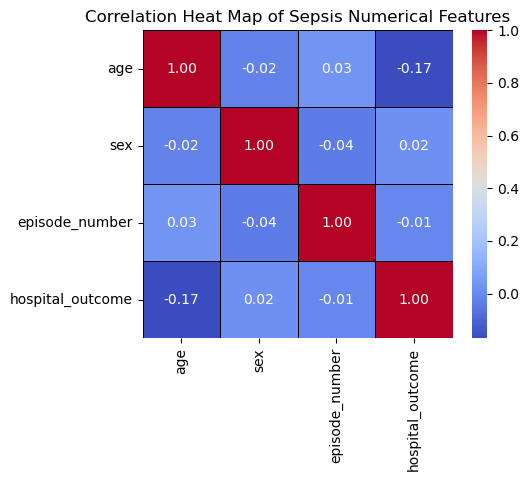

In [10]:
numeric_cols = ["age", "sex", "episode_number", "hospital_outcome"]
corr_df = train_df[numeric_cols]

# Calculate the correlation matrix for the selected columns
correlation_matrix = corr_df.corr()

# Generate Heat Map
plt.figure(figsize=(5, 4))
sns.heatmap(
    correlation_matrix,
    annot=True,        # Display correlation values
    cmap='coolwarm',   # Use a diverging color map
    fmt=".2f",         # Format numbers to two decimal places
    linewidths=0.5,    # Add lines between cells
    linecolor='black'
)
plt.title('Correlation Heat Map of Sepsis Numerical Features')
plt.show() #

From the correlation heatmap above, it seems like age is the factor that contributes to the hospital outcome the most due to its highest magnitude in correlation. Sex and episode number seem to have lower correlation values compared to age.

## Modeling 

Insert Sasha's Part here

## Methods

## Results & Discussion

## References

- Canadian Cancer Society / Société canadienne du cancer. (2024, January). Sepsis and septic shock. Canadian Cancer Society. https://cancer.ca/en/treatments/side-effects/septic-shock 
- Chicco, D. & Jurman, G. (2020). Sepsis Survival Minimal Clinical Records [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C53C8N.
- Cleveland Clinic. (2022, June). Septic shock: Causes, symptoms & treatment. https://my.clevelandclinic.org/health/diseases/23255-septic-shock
- World Health Organization. (2024, May 3). Sepsis. World Health Organization. https://www.who.int/news-room/fact-sheets/detail/sepsis